In [2]:
from pathlib import Path
from os.path import dirname, realpath
from datetime import datetime
import os
import shutil
import psutil
from typing import List, Union
from pycaret.anomaly import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import LSTM libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
#import BIRCH libraries
from sklearn.cluster import Birch
from sklearn import preprocessing
from scipy.spatial import distance

In [3]:
# SYSTEM = 'sockshop'
SYSTEM = 'trainticket'
# Define the main directory
TRAINING_DATA_FOLDER = Path(f"../../vuDevOps/data_collection/{SYSTEM}-training-data")
DATA_FOLDER = Path(f"../../vuDevOps/data_collection/{SYSTEM}-data/")

RESULTS_FOLDER = Path(f"../../experiment_results/{SYSTEM}-data")

AD_FOLDER = Path("../AD")
AD_MODELS = ["iforest", "svm", "lof", "knn"]

# SAVED_AD_MODELS_PATH = os.path.join(AD_FOLDER,"anomaly_detection_models")
# LOCAL_AD_MODELS = os.path.join(SAVED_AD_MODELS_PATH,SYSTEM)

In [4]:
def load_metrics(base_dir):
    data = []
    file_count = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("metrics.csv"):
                file_path = os.path.join(root, file)
                # print(f"Processing file: {file_path}")
                df = pd.read_csv(file_path)
                # Extract metadata from the file path
                parts = file_path.split(os.sep)
                scenario = parts[5]
                behavior = parts[6]
                if behavior == 'anomalous':
                    service = parts[7]
                    users = parts[8]
                    repetition = parts[9]
                else:
                    service = 'normal'
                    users = parts[7]
                    repetition = parts[8]
                
                df['scenario'] = scenario
                df['behavior'] = behavior
                df['service'] = service
                df['users'] = users
                df['repetition'] = repetition
                data.append(df)
                file_count += 1
    print(f"Total files loaded: {file_count}")
    return pd.concat(data, ignore_index=True)


In [5]:
data = load_metrics(DATA_FOLDER)
# data.to_csv("ts-combined.csv", index=False)
data

Total files loaded: 360


,time,rabbitmq_cpu,redis_cpu,ts-account-mongo_cpu,ts-admin-basic-info-service_cpu,ts-admin-order-service_cpu,ts-admin-route-service_cpu,ts-admin-travel-service_cpu,ts-admin-user-service_cpu,ts-assurance-mongo_cpu,...,ts-price-service_disk,ts-admin-order-service_disk,ts-train-service_disk,ts-auth-service_disk,ts-contacts-service_disk,ts-cancel-service_disk,ts-food-service_disk,ts-inside-payment-service_disk,ts-payment-service_disk,ts-ticket-office-service_disk
0,1.724279e+09,0.013905,0.006877,0.006896,0.001302,0.107491,0.001301,0.001322,0.162500,0.006887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.724279e+09,0.013779,0.006424,0.007118,0.001278,0.146066,0.001298,0.001234,0.222401,0.006822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.724279e+09,0.013511,0.006337,0.006512,0.001200,0.191556,0.001203,0.001206,0.267110,0.006471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.724279e+09,0.013299,0.006093,0.006380,0.001175,0.231320,0.001178,0.001160,0.349751,0.006143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.724279e+09,0.013209,0.005767,0.005848,0.001131,0.245268,0.001131,0.001128,0.377171,0.005691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21558,1.723245e+09,0.012311,0.002054,0.004207,0.001138,0.292938,0.000994,0.001076,0.209832,0.004535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21559,1.723245e+09,0.012526,0.002030,0.004412,0.001147,0.294536,0.000992,0.001081,0.202861,0.004540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21560,1.723245e+09,0.012467,0.001996,0.004277,0.001150,0.291079,0.000978,0.001087,0.192826,0.004603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21561,1.723245e+09,0.004159,0.001978,0.004342,0.001146,0.287693,0.000986,0.001085,0.185577,0.004572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Expected combinations
scenarios = ['scenario_A', 'scenario_B']
behaviors = ['anomalous', 'baseline']
services_anomalous = ['front-end', 'orders']
services_normal = ['normal']
users = ['100', '1000']
repetitions = [f'repetition_{i}' for i in range(1, 31)]

from itertools import product

expected_combinations = []

# Generate expected combinations for anomalous behavior
expected_combinations += list(product(scenarios, behaviors[0], services_anomalous, users, repetitions))

# Generate expected combinations for normal behavior
expected_combinations += list(product(scenarios, behaviors[1], services_normal, users, repetitions))

expected_count = len(expected_combinations)
print(f"Expected number of combinations (including repetitions): {expected_count}")

# Check if all expected combinations are present
grouped = data.groupby(['scenario', 'behavior', 'service', 'users', 'repetition']).size().reset_index(name='counts')
missing_combinations = [comb for comb in expected_combinations if not grouped[(grouped['scenario'] == comb[0]) & 
                                                                              (grouped['behavior'] == comb[1]) & 
                                                                              (grouped['service'] == comb[2]) & 
                                                                              (grouped['users'] == comb[3]) & 
                                                                              (grouped['repetition'] == comb[4])].empty]
print(f"Number of missing combinations: {len(missing_combinations)}")
if missing_combinations:
    print("Missing combinations:")
    for comb in missing_combinations:
        print(comb)


Missing values in each column:
time                                  0
rabbitmq_cpu                         61
redis_cpu                             0
ts-account-mongo_cpu                  0
ts-admin-basic-info-service_cpu       0
                                   ... 
repetition                            0
ts-avatar-service_disk             4920
ts-price-service_disk              7138
redis_disk                         7137
ts-ticket-office-service_disk      7138
Length: 382, dtype: int64
Expected number of combinations (including repetitions): 3120
Number of missing combinations: 0


In [6]:
def convert_data(data):
    # Convert UNIX timestamp to datetime
    data['time'] = pd.to_datetime(data['time'], unit='s')

    # Calculate time intervals
    data['time_intervals'] = data['time'].diff().dt.total_seconds().abs()
    data['time_intervals'].fillna(method="bfill", inplace=True)
    # Set the default time interval to 5 seconds where the interval is greater than 5 minutes (300s)
    data['time_intervals'] = data['time_intervals'].apply(lambda x: 5.0 if x > 300.0 else x)
    time_interval = data['time_intervals'].iloc[0]

    # Convert CPU usage to percentage
    cpu_columns = [col for col in data.columns if '_cpu' in col]
    data[cpu_columns] = data[cpu_columns] * 100

    # Calculate energy consumption from power consumption
    power_columns = [col for col in data.columns if '_power' in col]
    for col in power_columns:
        new_col_name = f"{col.split('_')[0]}_energy"
        data[new_col_name] = data[col] * data['time_intervals']

    return data, time_interval


In [7]:
converted_data, time_interval = convert_data(data)
# converted_data.to_csv("ts-converted.csv", index=False)
converted_data

,time,rabbitmq_cpu,redis_cpu,ts-account-mongo_cpu,ts-admin-basic-info-service_cpu,ts-admin-order-service_cpu,ts-admin-route-service_cpu,ts-admin-travel-service_cpu,ts-admin-user-service_cpu,ts-assurance-mongo_cpu,...,ts-travel-plan-service_energy,ts-travel-service_energy,ts-travel2-mongo_energy,ts-travel2-service_energy,ts-ui-dashboard_energy,ts-user-mongo_energy,ts-user-service_energy,ts-verification-code-service_energy,ts-voucher-mysql_energy,ts-voucher-service_energy
0,2024-08-21 22:23:18.192,1.390512,0.687690,0.689579,0.130182,10.749121,0.130064,0.132200,16.250002,0.688666,...,0.001289,0.073648,0.006083,0.003091,0.004476,0.009407,0.288284,0.211178,0.001991,0.0
1,2024-08-21 22:23:23.192,1.377945,0.642434,0.711784,0.127836,14.606641,0.129825,0.123399,22.240122,0.682240,...,0.001694,0.493790,0.007674,0.608337,0.012647,0.008960,0.487868,0.366498,0.001941,0.0
2,2024-08-21 22:23:28.192,1.351119,0.633734,0.651211,0.120046,19.155639,0.120329,0.120607,26.711011,0.647111,...,0.001477,1.000287,0.008861,1.202937,0.022762,0.009198,0.507628,0.412978,0.001724,0.0
3,2024-08-21 22:23:33.192,1.329885,0.609306,0.637953,0.117524,23.132036,0.117780,0.115963,34.975122,0.614327,...,0.001478,1.836066,0.009708,1.249717,0.031731,0.010263,0.743973,0.630640,0.001491,0.0
4,2024-08-21 22:23:38.192,1.320867,0.576684,0.584834,0.113051,24.526815,0.113073,0.112792,37.717094,0.569096,...,0.001268,2.336290,0.014780,1.644536,0.058377,0.014485,0.823290,0.790909,0.001872,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21558,2024-08-09 23:13:24.408,1.231139,0.205392,0.420739,0.113767,29.293796,0.099370,0.107644,20.983195,0.453459,...,0.002505,0.541013,0.019588,0.283046,0.181361,0.050821,1.520662,0.134427,0.003415,0.0
21559,2024-08-09 23:13:29.408,1.252612,0.203018,0.441184,0.114718,29.453645,0.099190,0.108064,20.286145,0.453983,...,0.002425,0.525921,0.019003,0.319424,0.178616,0.042955,1.483358,0.142729,0.003512,0.0
21560,2024-08-09 23:13:34.408,1.246694,0.199592,0.427718,0.114965,29.107899,0.097825,0.108670,19.282571,0.460321,...,0.002518,0.469584,0.018557,0.447385,0.177367,0.048334,1.581418,0.142344,0.003041,0.0
21561,2024-08-09 23:13:39.408,0.415949,0.197779,0.434184,0.114603,28.769310,0.098650,0.108515,18.557720,0.457152,...,0.002438,0.547708,0.019972,0.639776,0.148928,0.041041,1.350524,0.160099,0.002944,0.0


In [8]:
normal_data = converted_data[converted_data['behavior'] == 'baseline']
# normal_data.to_csv("ts-normal_data.csv", index=False)
normal_data

,time,rabbitmq_cpu,redis_cpu,ts-account-mongo_cpu,ts-admin-basic-info-service_cpu,ts-admin-order-service_cpu,ts-admin-route-service_cpu,ts-admin-travel-service_cpu,ts-admin-user-service_cpu,ts-assurance-mongo_cpu,...,ts-travel-plan-service_energy,ts-travel-service_energy,ts-travel2-mongo_energy,ts-travel2-service_energy,ts-ui-dashboard_energy,ts-user-mongo_energy,ts-user-service_energy,ts-verification-code-service_energy,ts-voucher-mysql_energy,ts-voucher-service_energy
7168,2024-08-09 10:15:23.848,1.450936,0.218353,0.754736,0.133300,11.200113,0.125493,0.129555,17.259491,0.711221,...,0.000745,0.166672,0.004939,0.002184,0.006879,0.007683,0.420444,0.310271,0.002338,0.0
7169,2024-08-09 10:15:28.848,1.384210,0.212740,0.718096,0.130706,14.727118,0.124600,0.121942,24.019037,0.683164,...,0.000736,0.917925,0.008210,0.779736,0.013061,0.007619,0.707769,0.394613,0.001960,0.0
7170,2024-08-09 10:15:33.848,1.418338,0.206328,0.676529,0.125456,17.125512,0.121467,0.119368,28.926008,0.641294,...,0.001411,1.777944,0.011549,1.146434,0.021855,0.007769,0.979448,0.466538,0.002233,0.0
7171,2024-08-09 10:15:38.848,1.376981,0.202560,0.660114,0.121697,22.150212,0.119030,0.115074,39.004124,0.627024,...,0.001233,3.127696,0.013007,1.248077,0.026826,0.007519,1.201822,0.682830,0.001996,0.0
7172,2024-08-09 10:15:43.848,1.374641,0.198314,0.618046,0.116707,24.792319,0.114734,0.110843,43.089411,0.569742,...,0.001183,4.200690,0.012969,2.073249,0.028027,0.011694,1.362059,0.917329,0.002614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21558,2024-08-09 23:13:24.408,1.231139,0.205392,0.420739,0.113767,29.293796,0.099370,0.107644,20.983195,0.453459,...,0.002505,0.541013,0.019588,0.283046,0.181361,0.050821,1.520662,0.134427,0.003415,0.0
21559,2024-08-09 23:13:29.408,1.252612,0.203018,0.441184,0.114718,29.453645,0.099190,0.108064,20.286145,0.453983,...,0.002425,0.525921,0.019003,0.319424,0.178616,0.042955,1.483358,0.142729,0.003512,0.0
21560,2024-08-09 23:13:34.408,1.246694,0.199592,0.427718,0.114965,29.107899,0.097825,0.108670,19.282571,0.460321,...,0.002518,0.469584,0.018557,0.447385,0.177367,0.048334,1.581418,0.142344,0.003041,0.0
21561,2024-08-09 23:13:39.408,0.415949,0.197779,0.434184,0.114603,28.769310,0.098650,0.108515,18.557720,0.457152,...,0.002438,0.547708,0.019972,0.639776,0.148928,0.041041,1.350524,0.160099,0.002944,0.0


In [9]:
energy_columns = [col for col in normal_data.columns if 'energy' in col]
cpu_columns = [col for col in normal_data.columns if 'cpu' in col]
max_energy_value = converted_data[energy_columns].max().max()
max_cpu_value = converted_data[cpu_columns].max().max()
melted_data = normal_data.melt(id_vars=['users', 'scenario'], value_vars=energy_columns, var_name='service', value_name='energy_usage')

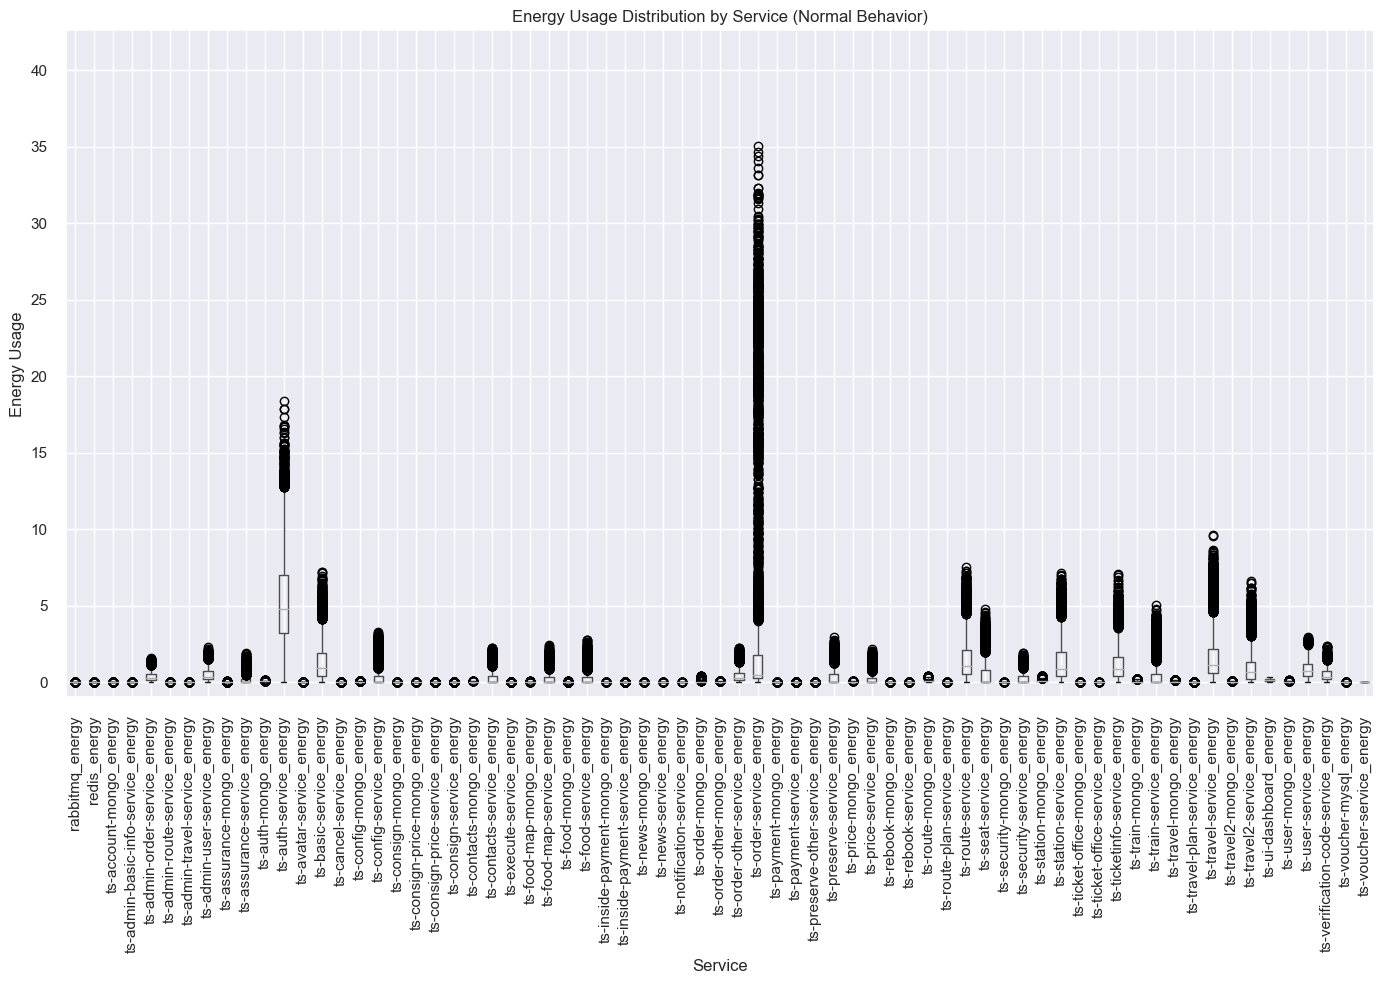

In [10]:
energy_columns = [col for col in normal_data.columns if 'energy' in col]
plt.figure(figsize=(14, 10))
normal_data[energy_columns].boxplot(rot=90)
# sns.boxplot(data=melted_data, x='service', y='energy_usage')
plt.title('Energy Usage Distribution by Service (Normal Behavior)')
plt.xlabel('Service')
plt.ylabel('Energy Usage')
plt.ylim(-1, max_energy_value)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# plt.figure(figsize=(14, 10))

# for col in energy_columns:
#     plt.plot(normal_data.index, normal_data[col], label=col)

# plt.title('Energy Usage Over Time for All Services')
# plt.xlabel('Time')
# plt.ylabel('Energy Usage')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [13]:
low_user_load = normal_data[(normal_data['users'] == "100")]
melted_low = low_user_load.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
high_user_load = normal_data[(normal_data['users'] == "1000")]
melted_high = high_user_load.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

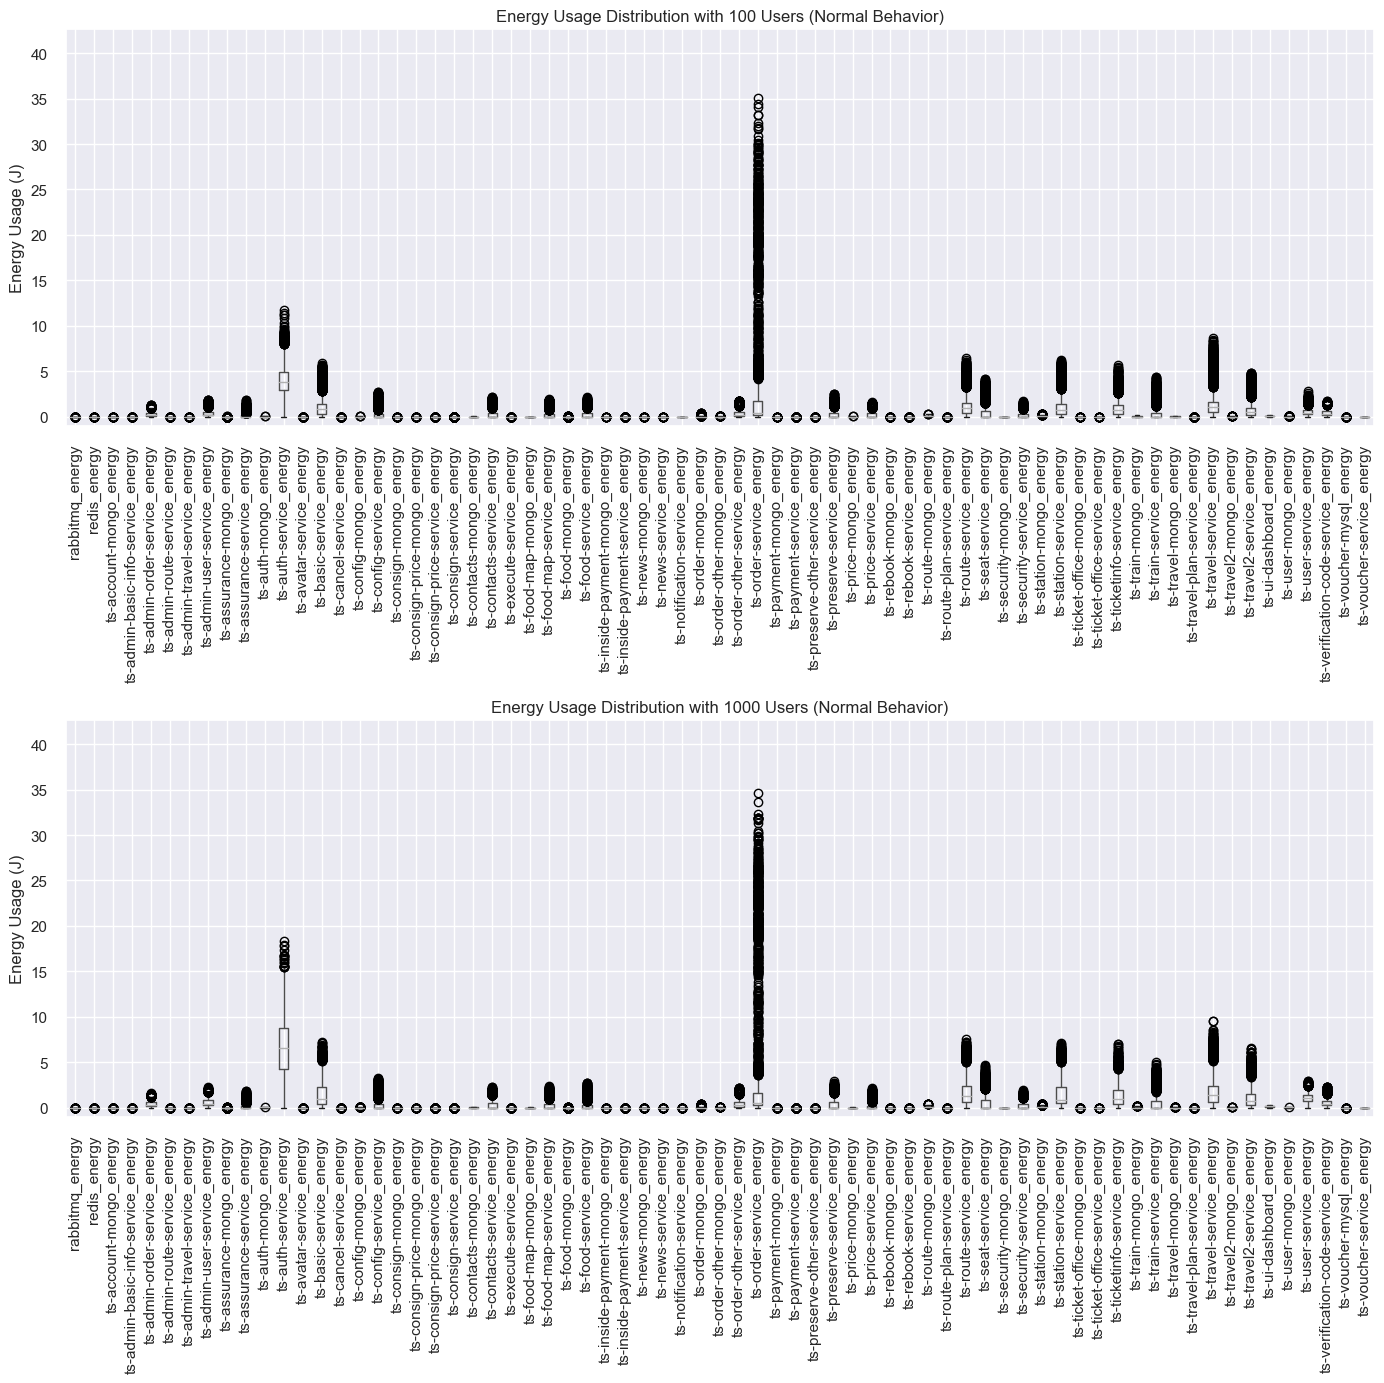

In [14]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
low_user_load[energy_columns].boxplot(rot=90)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_low, palette='tab20')
# sns.boxplot(x='service', y='energy_usage', hue='users', data=melted_data)
plt.title('Energy Usage Distribution with 100 Users (Normal Behavior)')
# plt.title('CPU Usage Distribution with 100 Users (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
high_user_load[energy_columns].boxplot(rot=90)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_high, palette='tab20')
plt.title('Energy Usage Distribution with 1000 Users (Normal Behavior)')
# plt.title('CPU Usage Distribution with 1000 Users (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [15]:
scenario_a = normal_data[(normal_data['scenario'] == "scenario_A")]
melted_a = scenario_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
scenario_b = normal_data[(normal_data['scenario'] == "scenario_B")]
melted_b = scenario_b.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

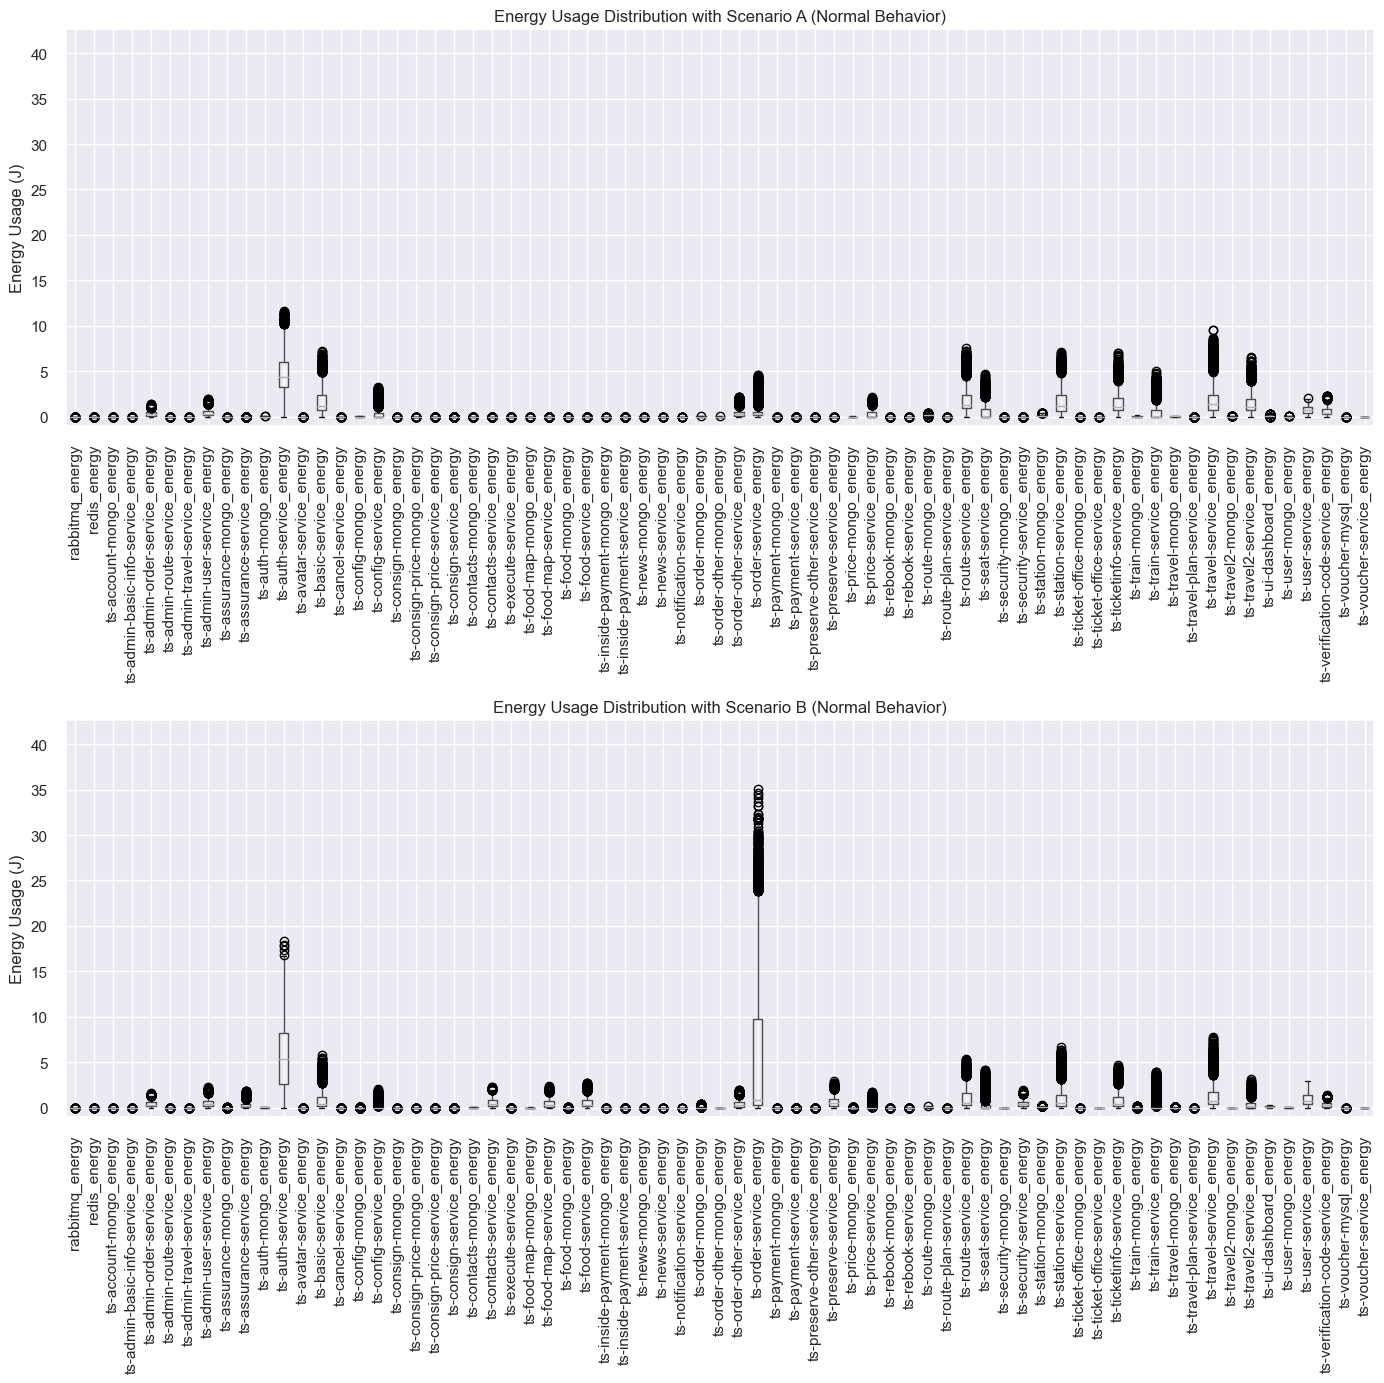

In [16]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_a, palette='tab20')
scenario_a[energy_columns].boxplot(rot=90)
# sns.boxplot(x='service', y='energy_usage', hue='scenario', data=melted_data)
plt.title('Energy Usage Distribution with Scenario A (Normal Behavior)')
# plt.title('CPU Usage Distribution with Scenario A (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_b, palette='tab20')
scenario_b[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with Scenario B (Normal Behavior)')
# plt.title('CPU Usage Distribution with Scenario B (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [18]:
anomalous_data = converted_data[converted_data['behavior'] == 'anomalous']
anomalous_data.to_csv("ts-anomalous_data.csv", index=False)
energy_columns = [col for col in anomalous_data.columns if 'energy' in col]
cpu_columns = [col for col in anomalous_data.columns if 'cpu' in col]
anomalous_data

,time,rabbitmq_cpu,redis_cpu,ts-account-mongo_cpu,ts-admin-basic-info-service_cpu,ts-admin-order-service_cpu,ts-admin-route-service_cpu,ts-admin-travel-service_cpu,ts-admin-user-service_cpu,ts-assurance-mongo_cpu,...,ts-travel-plan-service_energy,ts-travel-service_energy,ts-travel2-mongo_energy,ts-travel2-service_energy,ts-ui-dashboard_energy,ts-user-mongo_energy,ts-user-service_energy,ts-verification-code-service_energy,ts-voucher-mysql_energy,ts-voucher-service_energy
0,2024-08-21 22:23:18.192,1.390512,0.687690,0.689579,0.130182,10.749121,0.130064,0.132200,16.250002,0.688666,...,0.001289,0.073648,0.006083,0.003091,0.004476,0.009407,0.288284,0.211178,0.001991,0.0
1,2024-08-21 22:23:23.192,1.377945,0.642434,0.711784,0.127836,14.606641,0.129825,0.123399,22.240122,0.682240,...,0.001694,0.493790,0.007674,0.608337,0.012647,0.008960,0.487868,0.366498,0.001941,0.0
2,2024-08-21 22:23:28.192,1.351119,0.633734,0.651211,0.120046,19.155639,0.120329,0.120607,26.711011,0.647111,...,0.001477,1.000287,0.008861,1.202937,0.022762,0.009198,0.507628,0.412978,0.001724,0.0
3,2024-08-21 22:23:33.192,1.329885,0.609306,0.637953,0.117524,23.132036,0.117780,0.115963,34.975122,0.614327,...,0.001478,1.836066,0.009708,1.249717,0.031731,0.010263,0.743973,0.630640,0.001491,0.0
4,2024-08-21 22:23:38.192,1.320867,0.576684,0.584834,0.113051,24.526815,0.113073,0.112792,37.717094,0.569096,...,0.001268,2.336290,0.014780,1.644536,0.058377,0.014485,0.823290,0.790909,0.001872,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17956,2024-08-21 01:45:12.016,0.381288,0.423388,0.443704,0.111005,2.471337,0.107576,0.106237,0.324243,0.548334,...,0.002930,3.290300,0.010215,0.004433,0.032213,0.012339,0.012821,0.023206,0.004587,0.0
17957,2024-08-21 01:45:17.016,1.087342,0.444521,0.479672,0.112053,2.479598,0.119155,0.115497,0.361750,0.551664,...,0.003717,3.694854,0.009947,0.004474,0.031981,0.012428,0.015556,0.023018,0.004462,0.0
17958,2024-08-21 01:45:22.016,1.098779,0.459250,0.477799,0.112988,2.562758,0.118272,0.115831,0.342005,0.606425,...,0.003273,3.680823,0.010743,0.003895,0.024728,0.013088,0.016107,0.021596,0.004741,0.0
17959,2024-08-21 01:45:27.016,1.116447,0.480200,0.535586,0.112107,2.496165,0.137957,0.135232,0.357682,0.621508,...,0.003599,3.614030,0.011089,0.004199,0.027950,0.012386,0.014535,0.021629,0.003750,0.0


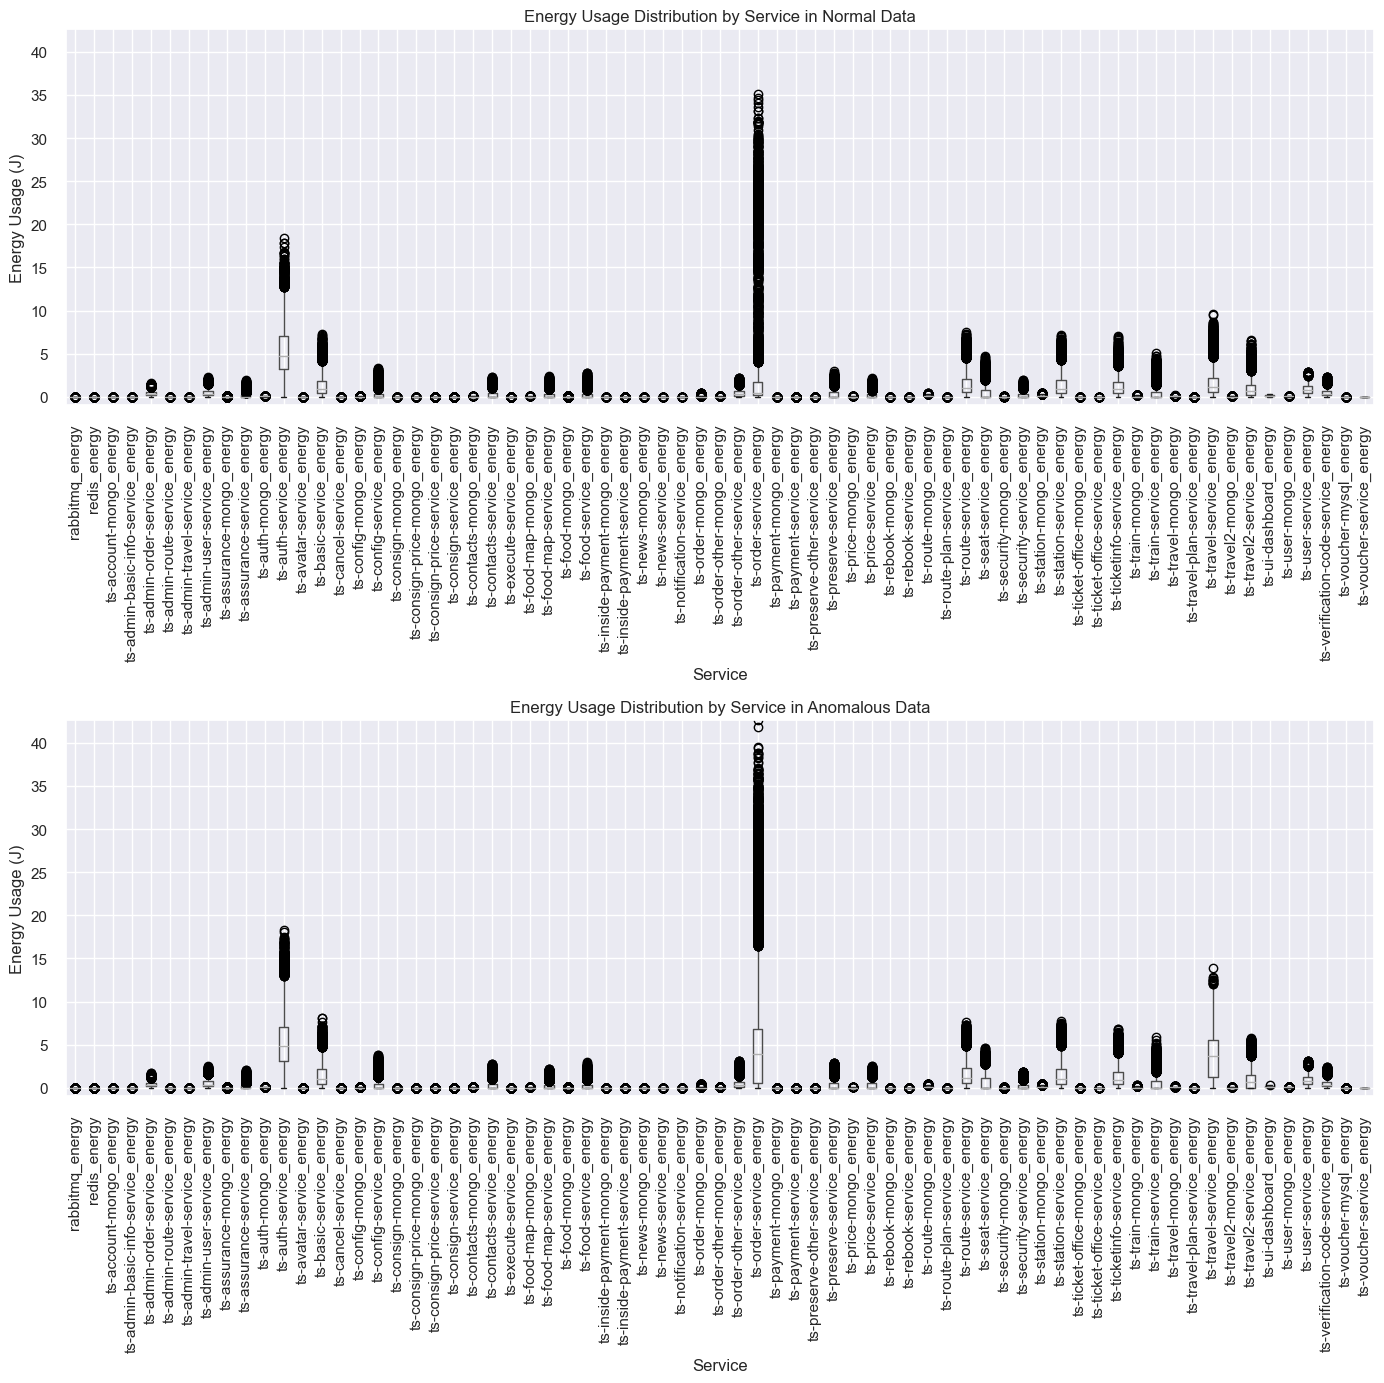

In [20]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
normal_data[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution by Service in Normal Data')
# plt.title('CPU Usage Distribution by Service in Normal Data')
plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.ylim(-1, max_energy_value)
plt.grid(True)

plt.subplot(2, 1, 2)
anomalous_data[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution by Service in Anomalous Data')
# plt.title('CPU Usage Distribution by Service in Anomalous Data')
plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.ylim(-1, max_energy_value)
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
low_user_load_a = anomalous_data[(anomalous_data['users'] == "100")]
melted_low_a = low_user_load_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
high_user_load_a = anomalous_data[(anomalous_data['users'] == "1000")]
melted_high_a = high_user_load_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

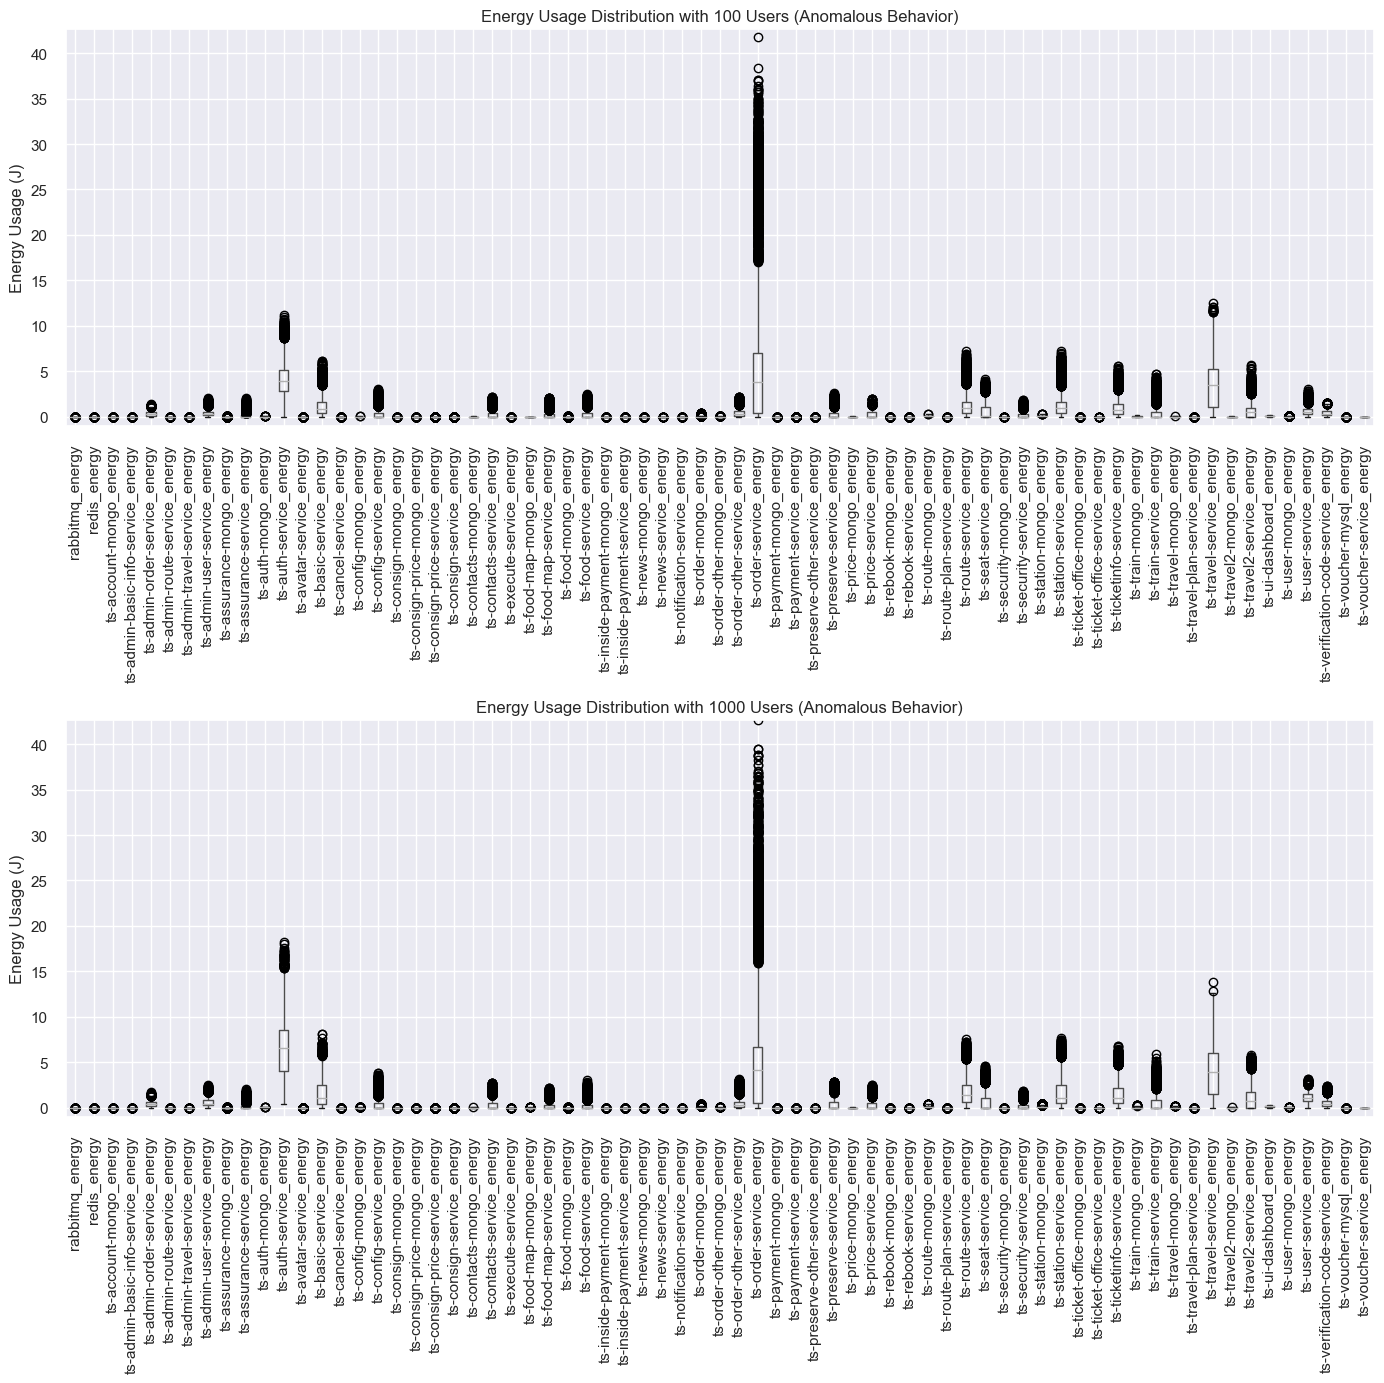

In [22]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_low_a, palette='tab20')
low_user_load_a[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with 100 Users (Anomalous Behavior)')
# plt.title('CPU Usage Distribution with 100 Users (Anomalous Behavior)')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_high_a, palette='tab20')
high_user_load_a[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with 1000 Users (Anomalous Behavior)')
# plt.title('CPU Usage Distribution with 1000 Users (Anomalous Behavior)')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [23]:
stressed_scenario_a = anomalous_data[(anomalous_data['scenario'] == "scenario_A")]
stressed_melted_a = stressed_scenario_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
stressed_scenario_b = anomalous_data[(anomalous_data['scenario'] == "scenario_B")]
stressed_melted_b = stressed_scenario_b.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

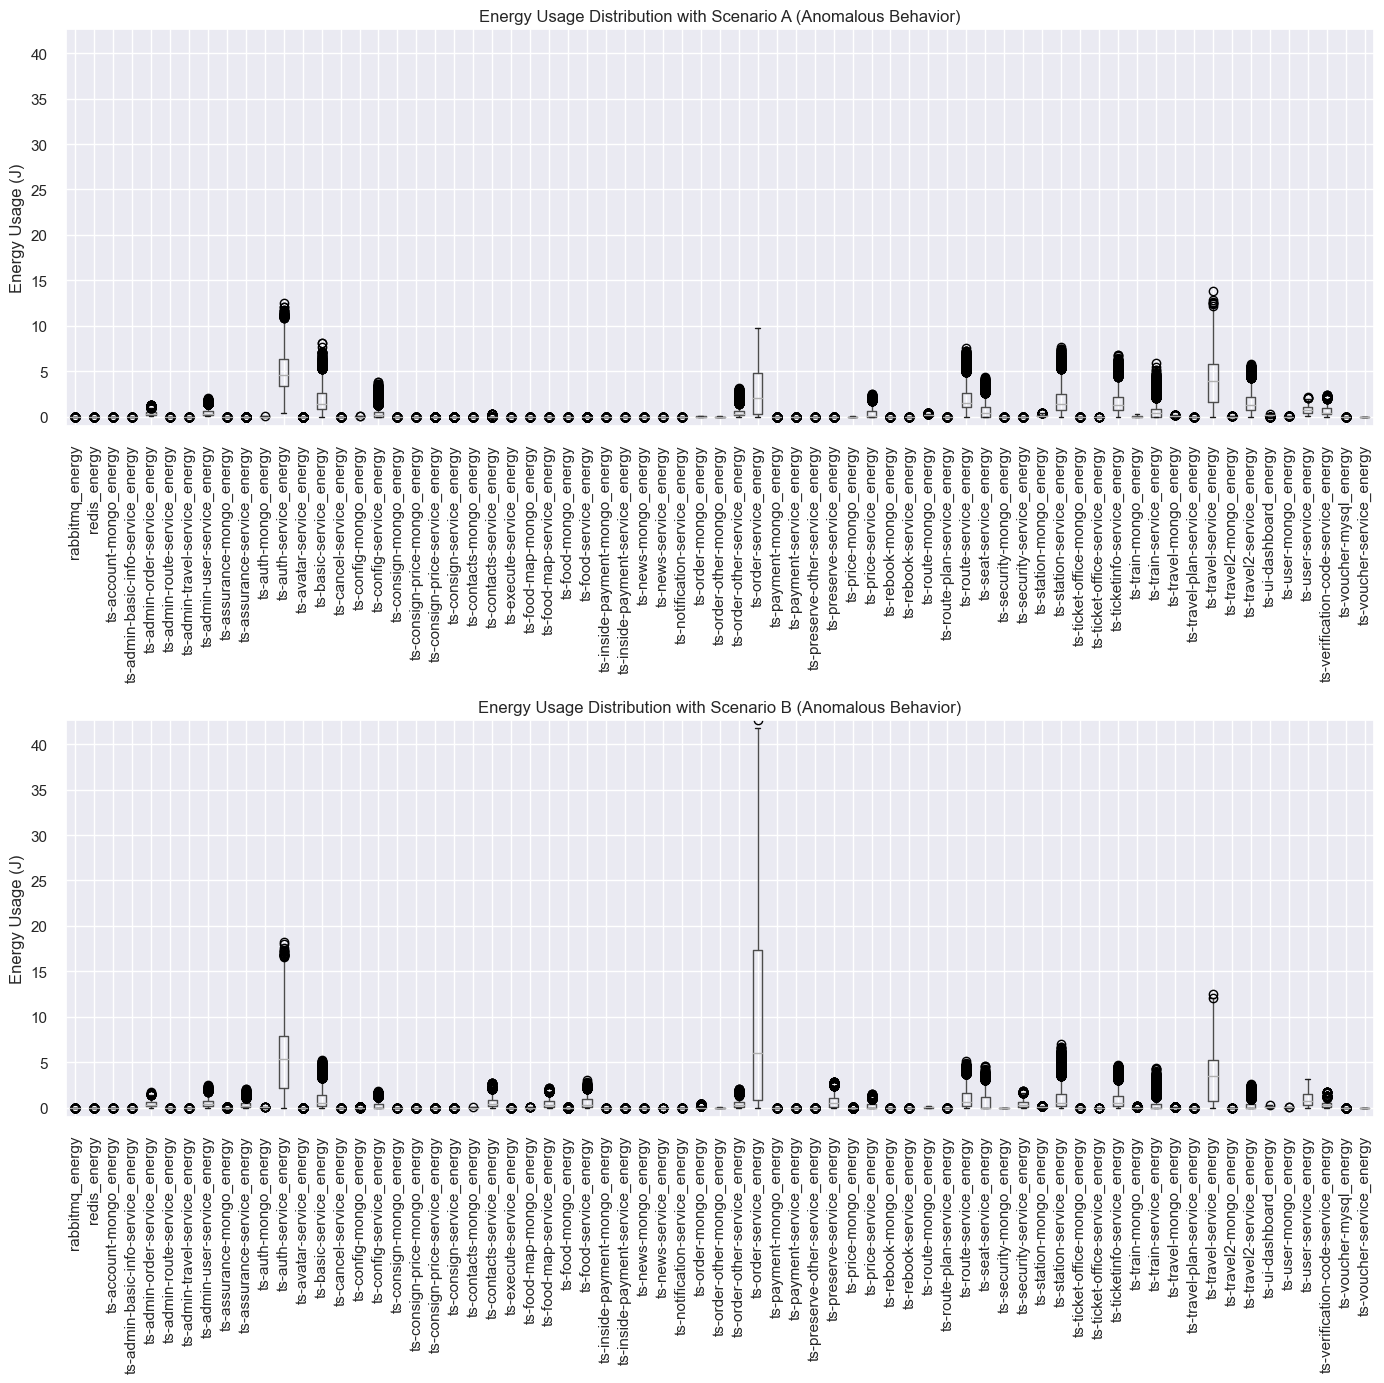

In [25]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_a, palette='tab20')
stressed_scenario_a[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with Scenario A (Anomalous Behavior)')
# plt.title('CPU Usage Distribution with Scenario A (Anomalous Behavior)')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_b, palette='tab20')
stressed_scenario_b[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with Scenario B (Anomalous Behavior)')
# plt.title('CPU Usage Distribution with Scenario B (Anomalous Behavior)')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [28]:
service_1 = anomalous_data[(anomalous_data['service'] == "ts-travel-service")]
stressed_melted_front = service_1.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
service_2 = anomalous_data[(anomalous_data['service'] == "ts-order-service")]
stressed_melted_orders = service_2.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

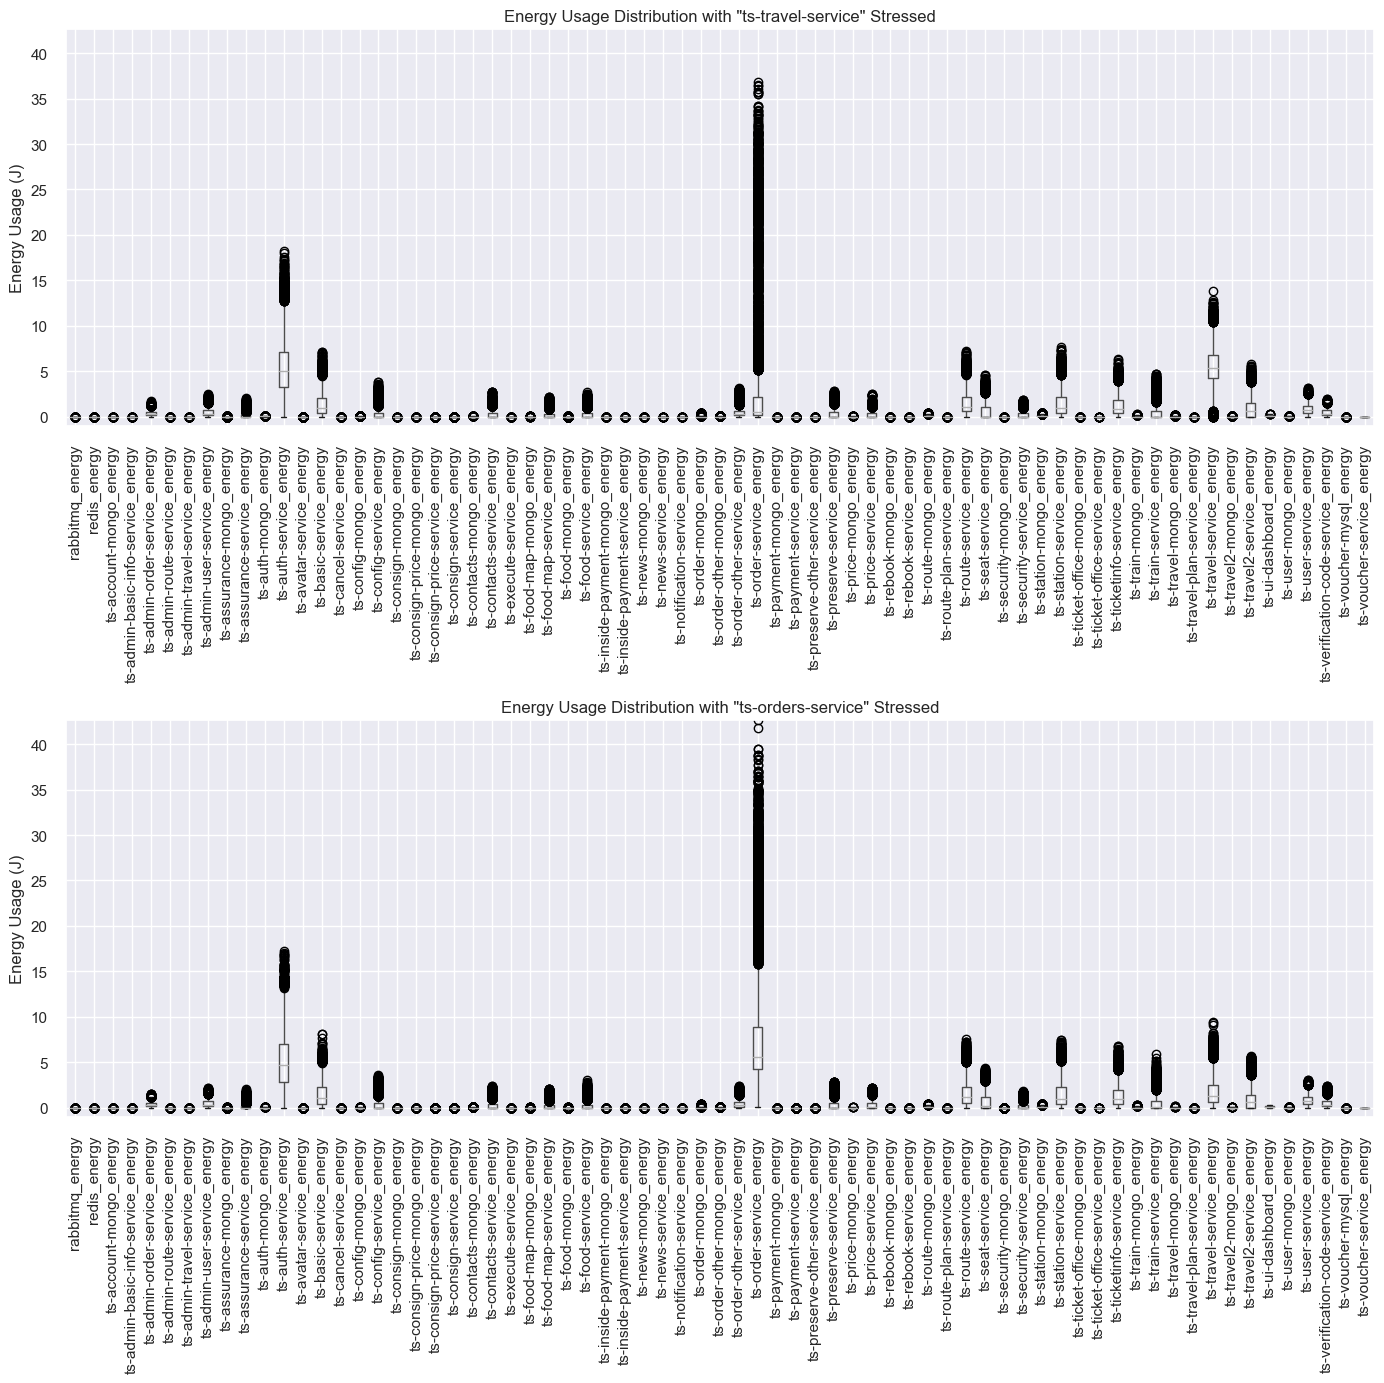

In [29]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_front, palette='tab20')
service_1[energy_columns].boxplot(rot=45)
plt.title('Energy Usage Distribution with "ts-travel-service" Stressed')
# plt.title('CPU Usage Distribution with "front-end" Service Stressed')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_orders, palette='tab20')
service_2[energy_columns].boxplot(rot=45)
plt.title('Energy Usage Distribution with "ts-order-service" Stressed')
# plt.title('CPU Usage Distribution with "orders" Service Stressed')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [32]:
def train_pycaret_AD_models(train_df, user, scenario):
    os.makedirs("anomaly_detection_models", exist_ok=True)

    train_df.replace(0, np.nan, inplace=True)
    
    # For each type of AD model to be used, create and train a model instance on the normal data
    for model in AD_MODELS:
        for column in train_df.columns:
            if "time" in column or "_energy" not in column:
                continue 
            print("Training anomaly detection models on normal data...")
            print(f"Training {model} model for {scenario}-{user} factors...")
            
            # Train model on Time & Energy dataframe
            col_data = train_df.loc[:, ["time", column]]
            setup(col_data, session_id = 123)
            
            # Train the model
            trained_model = create_model(model)
            
            resource_dir = os.path.join("anomaly_detection_models", SYSTEM, f'{scenario}_{user}_{column}')
            os.makedirs(resource_dir, exist_ok=True)
            
            # Save the model
            save_model(
                trained_model,
                f"{resource_dir}/{model}_pipeline",
            )

In [ ]:
scenarios = normal_data['scenario'].unique()
users = normal_data['users'].unique()

# Dictionary to hold filtered dataframes
filtered_data_dict = {}

# Loop through each combination and filter the data
# for scenario in scenarios:
#     for user in users:
#         combination_key = f"{scenario}_{user}"
#         filtered_data_dict[combination_key] = normal_data[(normal_data['scenario'] == scenario) & (normal_data['users'] == user)]
#         train_pycaret_AD_models(filtered_data_dict[combination_key], user, scenario)



In [96]:
def is_anomaly(value, mean, std, z_score_threshold=2):
    return abs(value - mean) > (z_score_threshold *std)

def create_ground_truth() -> None:
    """
    Indicates which of the data in each collected <metrics>.csv file are considered an anomaly
    based on the threshold value.
    """
    mean_values = normal_data.mean(numeric_only=True)
    std_values = normal_data.std(numeric_only=True)
    
    anomaly_df = anomalous_data.copy()
    
    for column in mean_values.index:
        anomaly_column = f"{column}_Anomaly"
        anomaly_df[anomaly_column] = anomalous_data[column].apply(
            lambda x: 1 if is_anomaly(x, mean_values[column], std_values[column]) else 0
        )
    
    anomaly_df.to_csv('ground_truth.csv', index=False)
    return anomaly_df
            
 

In [97]:
ground_truth = create_ground_truth()

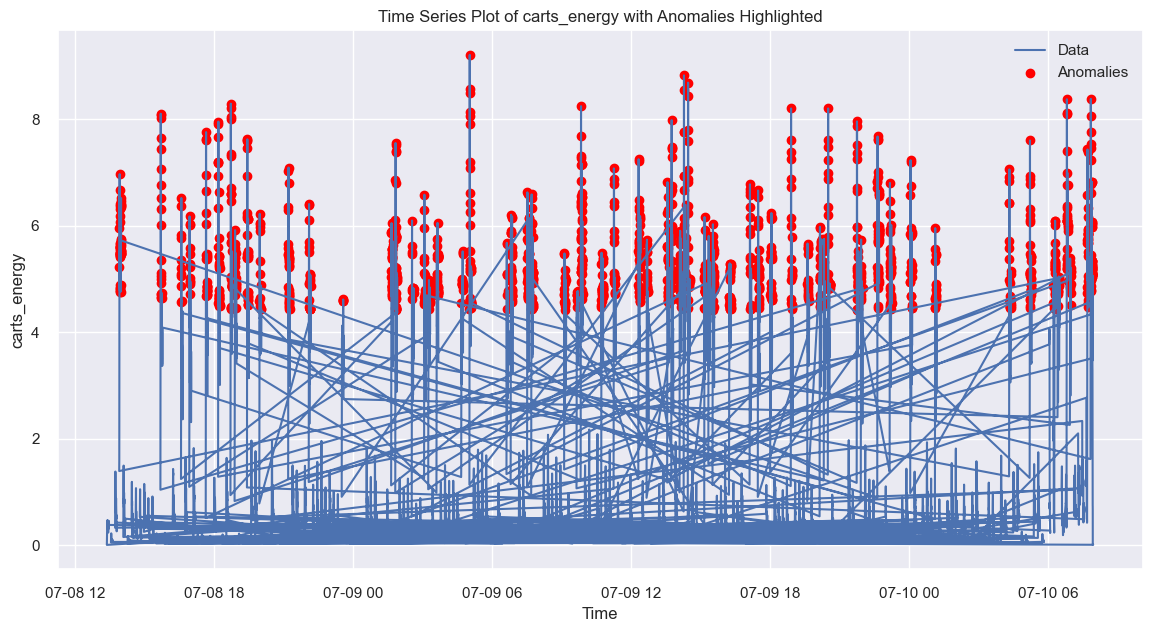

In [67]:
column_to_plot = 'carts_energy'  # Replace with the actual column name
anomaly_column = f"{column_to_plot}_Anomaly"

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(ground_truth['time'], ground_truth[column_to_plot], label='Data')

# Highlight anomalies
anomalies = ground_truth[ground_truth[anomaly_column] == 1]
plt.scatter(anomalies['time'], anomalies[column_to_plot], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel(column_to_plot)
plt.title(f'Time Series Plot of {column_to_plot} with Anomalies Highlighted')
plt.legend()
plt.show()

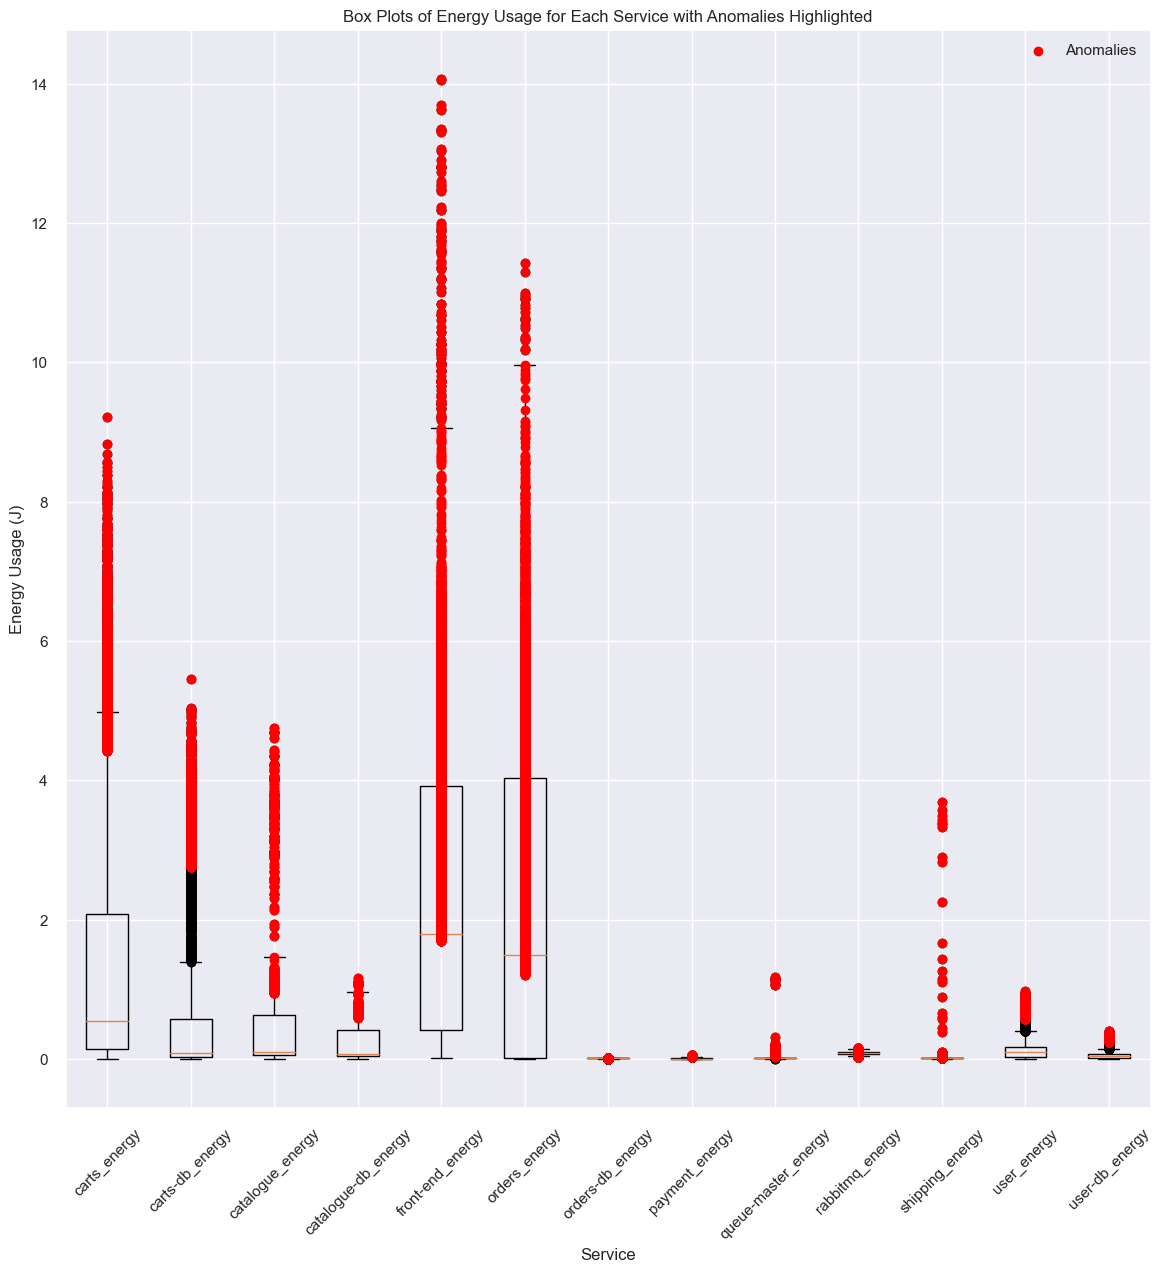

In [68]:
anomaly_columns = [f"{col}_Anomaly" for col in energy_columns]
data_to_plot = [ground_truth[col] for col in energy_columns]

plt.figure(figsize=(14, 14))
plt.boxplot(data_to_plot, labels=energy_columns)

for i, column in enumerate(energy_columns):
    anomaly_column = f"{column}_Anomaly"
    anomalies = ground_truth[ground_truth[anomaly_column] == 1]
    plt.scatter([i + 1] * len(anomalies), anomalies[column], color='red', label='Anomalies' if i == 0 else "", zorder=10)

# Set labels and title
plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
plt.title('Box Plots of Energy Usage for Each Service with Anomalies Highlighted')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [98]:
class AlgorithmProfiler:
    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.start_time = None
        self.end_time = None
        self.cpu_usage = []
        self.memory_usage = []

    def _monitor_resources(self):
        process = psutil.Process()
        self.cpu_usage.append(process.cpu_percent(interval=1))
        self.memory_usage.append(process.memory_info().rss / (1024 ** 2))  # Memory in MB

    def run(self, *args, **kwargs):
        self.start_time = datetime.now()
        print(f"Starting algorithm at {self.start_time}")

        try:
            while True:
                self._monitor_resources()
                result = self.algorithm(*args, **kwargs)
                break  # Exit after the algorithm is done
        finally:
            self.end_time = datetime.now()
            print(f"Algorithm completed at {self.end_time}")

            avg_cpu_usage = sum(self.cpu_usage) / len(self.cpu_usage)
            avg_memory_usage = sum(self.memory_usage) / len(self.memory_usage)

            print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")
            print(f"Average Memory Usage: {avg_memory_usage:.2f} MB")
            print(f"Total Execution Time: {self.end_time - self.start_time}")

        return result, {
            "start_time": self.start_time,
            "end_time": self.end_time,
            "avg_cpu_usage": avg_cpu_usage,
            "avg_memory_usage": avg_memory_usage,
            "execution_time": self.end_time - self.start_time
        }

In [99]:
def run_BIRCH_AD_with_smoothing(temp_df, df, column):    
    ad_threshold = 0.045  
    smoothing_window = 12
    test_df = df.loc[:, ["time", column]].copy()            

    for svc, energy in test_df.items():
        if svc != 'time':
            energy = energy.rolling(window=smoothing_window, min_periods=1).mean()
            x = np.array(energy)
            x = np.where(np.isnan(x), 0, x)
            normalized_x = preprocessing.normalize([x])

            X = normalized_x.reshape(-1,1)

            birch = Birch(branching_factor=50, n_clusters=None, threshold=ad_threshold, compute_labels=True)
            birch.fit(X)
            birch.predict(X)

            # Calculate distances to cluster centers
            distances = distance.cdist(X, birch.subcluster_centers_)
            min_distances = np.min(distances, axis=1)

            # Set threshold to identify anomalies
            threshold = np.percentile(min_distances, 95)

            # Assign anomaly labels
            test_df['anomaly_label'] = np.where(min_distances > threshold, 1, 0)
            
            temp_df = temp_df.assign(
                **{
                    f"{column}_Anomaly": test_df['anomaly_label'],
                    f"{column}_Anomaly_Score": min_distances,
                }
            )   
    return temp_df
               



In [102]:
def execute_AD_models():
    metrics_df = pd.DataFrame(columns=['algorithm', 'scenario', 'service', 'users', 'column', 'start_time', 'end_time', 'avg_cpu_usage', 'avg_memory_usage', 'execution_time'])
    
    unique_combinations = anomalous_data[['scenario', 'service', 'users']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        scenario = row['scenario']
        service_stressed = row['service']
        users = row['users']

        # Filter the DataFrame for the current combination
        temp_df = anomalous_data[(anomalous_data['scenario'] == scenario) & (anomalous_data['service'] == service_stressed) & (anomalous_data['users'] == users)].copy()

        # Initialize dictionaries to hold results for each model
        birch_results = temp_df.copy()
        ad_model_results = {}

        for column in temp_df.columns:
            if "time" in column or "_energy" not in column:
                continue

            # Directory structure for storing results
            result_dir = os.path.join("results", SYSTEM, scenario, service_stressed, users)
            os.makedirs(result_dir, exist_ok=True)

            # Run BIRCH algorithm
            profiler = AlgorithmProfiler(run_BIRCH_AD_with_smoothing)
            birch_col_results, birch_metrics = profiler.run(temp_df, temp_df, column)

            # Add BIRCH results to the BIRCH results DataFrame
            birch_results[f'{column}_Anomaly'] = birch_col_results[f'{column}_Anomaly']
            birch_results[f'{column}_Anomaly_Score'] = birch_col_results[f'{column}_Anomaly_Score']

            birch_metrics.update({
                'algorithm': 'BIRCH',
                'scenario': scenario,
                'service': service_stressed,
                'users': users,
                'column': column
            })
            metrics_df = pd.concat([metrics_df, pd.DataFrame([birch_metrics])], ignore_index=True)

            print("BIRCH metrics:", birch_metrics)

            # Run the previously trained algorithms
            train_model_column = f'{scenario}_{users}_{column}'
            model_folder_path = os.path.join("anomaly_detection_models", SYSTEM, train_model_column)
            for ad_model in os.listdir(model_folder_path):
                if ad_model not in ad_model_results:
                    ad_model_results[ad_model] = temp_df.copy()

                print(f"Executing for {scenario}, {service_stressed}, {users}, {ad_model}, {column}, Train Model = {train_model_column}")

                # Run SVM, KNN, LOF, and iForest algorithms
                setup(temp_df, session_id = 123, verbose = False)
                model_path = os.path.join(model_folder_path, f"{ad_model.split('_')[0]}_pipeline")
                trained_model = load_model(model_path, verbose = False)
                col_df = temp_df.loc[:, ["time", column]]
                
                col_df.replace(0, np.nan, inplace=True)
                col_df["time"] = pd.to_datetime(col_df["time"], unit="s")
                profiler = AlgorithmProfiler(predict_model)
                anomaly_results, ad_metrics = profiler.run(trained_model, data=col_df)

                # Add model results to the corresponding model's DataFrame
                ad_model_results[ad_model][f'{column}_Anomaly'] = anomaly_results["Anomaly"]
                ad_model_results[ad_model][f'{column}_Anomaly_Score'] = anomaly_results["Anomaly_Score"]

                ad_metrics.update({
                    'algorithm': ad_model.split('_')[0],
                    'scenario': scenario,
                    'service': service_stressed,
                    'users': users,
                    'column': column
                })
                metrics_df = pd.concat([metrics_df, pd.DataFrame([ad_metrics])], ignore_index=True)
                print(f"{ad_model.split('_')[0]} metrics:", ad_metrics)

        # Save BIRCH results to a CSV file
        birch_result_path = os.path.join(result_dir, f'BIRCH_results.csv')
        birch_results.to_csv(birch_result_path, index=False)

        # Save each algorithm's results to their respective CSV files
        for ad_model, results_df in ad_model_results.items():
            model_result_path = os.path.join(result_dir, f'{ad_model.split("_")[0]}_results.csv')
            results_df.to_csv(model_result_path, index=False)

    # Save the aggregated metrics to a single CSV file
    metrics_df.to_csv('anomaly_detection_execution_metrics.csv', index=False)


In [103]:
result = execute_AD_models()

Starting algorithm at 2024-08-16 11:12:35.367192
Algorithm completed at 2024-08-16 11:12:36.401198
Average CPU Usage: 0.00%
Average Memory Usage: 497.86 MB
Total Execution Time: 0:00:01.034006
BIRCH metrics: {'start_time': datetime.datetime(2024, 8, 16, 11, 12, 35, 367192), 'end_time': datetime.datetime(2024, 8, 16, 11, 12, 36, 401198), 'avg_cpu_usage': 0.0, 'avg_memory_usage': 497.85546875, 'execution_time': datetime.timedelta(seconds=1, microseconds=34006), 'algorithm': 'BIRCH', 'scenario': 'scenario_A', 'service': 'front-end', 'users': '100', 'column': 'carts_energy'}
Executing for scenario_A, front-end, 100, iforest_pipeline.pkl, carts_energy, Train Model = scenario_A_100_carts_energy
Starting algorithm at 2024-08-16 11:12:36.699741
Algorithm completed at 2024-08-16 11:12:37.822224
Average CPU Usage: 0.00%
Average Memory Usage: 498.43 MB
Total Execution Time: 0:00:01.122483
iforest metrics: {'start_time': datetime.datetime(2024, 8, 16, 11, 12, 36, 699741), 'end_time': datetime.date